# Lab | Text Generation from Shakespeare's Sonnet

This notebook explores the fascinating domain of text generation using a deep learning model trained on Shakespeare's sonnets.

The objective is to create a neural network capable of generating text sequences that mimic the style and language of Shakespeare.

By utilizing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers, this project aims to demonstrate how a model can learn and replicate the complex patterns of early modern English.

The dataset used consists of Shakespeare's sonnets, which are preprocessed and tokenized to serve as input for the model.

Throughout this notebook, you will see the steps taken to prepare the data, build and train the model, and evaluate its performance in generating text.

This lab provides a hands-on approach to understanding the intricacies of natural language processing (NLP) and the potential of machine learning in creative text generation.

Let's import necessary libraries

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
import numpy as np

Let's get the data!

In [2]:
import requests
url = 'https://raw.githubusercontent.com/martin-gorner/tensorflow-rnn-shakespeare/master/shakespeare/sonnets.txt'
resp = requests.get(url)
with open('sonnets.txt', 'wb') as f:
    f.write(resp.content)

data = open('sonnets.txt').read()

corpus = data.lower().split("\n")

Step 1: Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts

In [3]:
# Initialize the tokenizer
tokenizer = Tokenizer()

# Step 2: Fit tokenizer on the corpus
tokenizer.fit_on_texts(corpus)

Step 2: Calculate the Vocabulary Size

Let's figure out how many unique words are in your corpus. This will be the size of your vocabulary.

Calculate the length of tokenizer.word_index, add 1 to it and store it in a variable called total_words.

In [4]:
total_words = len(tokenizer.word_index) + 1


Create an empty list called input_sequences.

For each sentence in your corpus, convert the text into a sequence of integers using the tokenizer.
Then, generate n-gram sequences from these tokens.

Store the result in the list input_sequences.

In [5]:
input_sequences = []

for line in corpus:  # assuming corpus is a list of sentences
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list) + 1):
        n_gram_sequence = token_list[:i]
        input_sequences.append(n_gram_sequence)


Calculate the length of the longest sequence in input_sequences. Assign the result to a variable called max_sequence_len.

Now pad the sequences using pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre').
Convert it to a numpy array and assign the result back to our variable called input_sequences.

In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Find the length of the longest sequence
max_sequence_len = max(len(seq) for seq in input_sequences)

# Pad sequences and convert to numpy array
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')
input_sequences = np.array(input_sequences)


Prepare Predictors and Labels

Split the sequences into two parts:

- Predictors: All elements from input_sequences except the last one.
- Labels: The last element of each sequence in input_sequences.

In [ ]:
# All columns except the last one
predictors = input_sequences[:, :-1]

# Only last column
labels = input_sequences[:, -1]


One-Hot Encode the Labels :

Convert the labels (which are integers) into one-hot encoded vectors.

Ensure the length of these vectors matches the total number of unique words in your vocabulary.

Use ku.to_categorical() on labels with num_classes = total_words

Assign the result back to our variable labels.

In [8]:
from tensorflow.keras.utils import to_categorical

labels = to_categorical(labels, num_classes=total_words)


# Initialize the Model

Start by creating a Sequential model.

Add Layers to the Model:

Embedding Layer: The first layer is an embedding layer. It converts word indices into dense vectors of fixed size (100 in this case). Set the input length to the maximum sequence length minus one, which corresponds to the number of previous words the model will consider when predicting the next word.

Bidirectional LSTM Layer: Add a Bidirectional LSTM layer with 150 units. This layer allows the model to learn context from both directions (past and future) in the sequence. return_sequences=True

Dropout Layer: Add a dropout layer with a rate of 0.2 to prevent overfitting by randomly setting 20% of the input units to 0 during training.

LSTM Layer: Add a second LSTM layer with 100 units. This layer processes the sequence and passes its output to the next layer.

Dense Layer (Intermediate): Add a dense layer with half the total number of words as units, using ReLU activation. A regularization term (L2) is added to prevent overfitting.

Dense Layer (Output): The final dense layer has as many units as there are words in the vocabulary, with a softmax activation function to output a probability distribution over all words.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.regularizers import l2

model = Sequential([
    Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_len-1),
    Bidirectional(LSTM(150, return_sequences=True)),
    Dropout(0.2),
    LSTM(100),
    Dense(total_words//2, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(total_words, activation='softmax')
])


# model = Sequential( model.add(Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_len-1))

# # Bidirectional LSTM layer
# model.add(Bidirectional(LSTM(150, return_sequences=True)))

# # Dropout layer
# model.add(Dropout(0.2))

# # Second LSTM layer
# model.add(LSTM(100))

# # Dense layer (intermediate) with L2 regularization
# model.add(Dense(total_words//2, activation='relu', kernel_regularizer=l2(0.01)))

# # Dense layer (output) with softmax
# model.add(Dense(total_words, activation='softmax'))

# # Summary to check the model
# model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# Compile the Model:

Compile the model using categorical crossentropy as the loss function, the Adam optimizer for efficient training, and accuracy as the metric to evaluate during training.

In [10]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


# Print Model Summary:

Use model.summary() to print a summary of the model, which shows the layers, their output shapes, and the number of parameters.

In [11]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


# Now train the model for 50 epochs and assign it to a variable called history.

Training the model with 50 epochs should get you around 40% accuracy.

You can train the model for as many epochs as you like depending on the time and computing constraints you are facing. Ideally train it for a larger amount of epochs than 50.

That way you will get better text generation at the end.

However, dont waste your time.

In [17]:
history = model.fit(
    predictors,
    labels,
    epochs=50,
    verbose=1
)


Epoch 1/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.0252 - loss: 7.2192
Epoch 2/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.0252 - loss: 6.4047
Epoch 3/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.0315 - loss: 6.3268
Epoch 4/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.0344 - loss: 6.2098
Epoch 5/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.0373 - loss: 6.1305
Epoch 6/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.0447 - loss: 6.0616
Epoch 7/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.0508 - loss: 5.9654
Epoch 8/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.0566 - loss: 5.8864
Epoch 9/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.0569 - loss: 5.8009
Epoch 10/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.0608 - loss: 5.7175
Epoch 11/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.0705 - loss: 5.5942
Epoch 12/50
557/557 ━━━━━━━━━━━

# Use plt from matplotlib to plot the training accuracy over epochs and the loss over epochs

First you will have to get the accuracy and loss data over epochs, you can do this by using methods on your model.

In [19]:
acc = history.history['accuracy']
loss = history.history['loss']


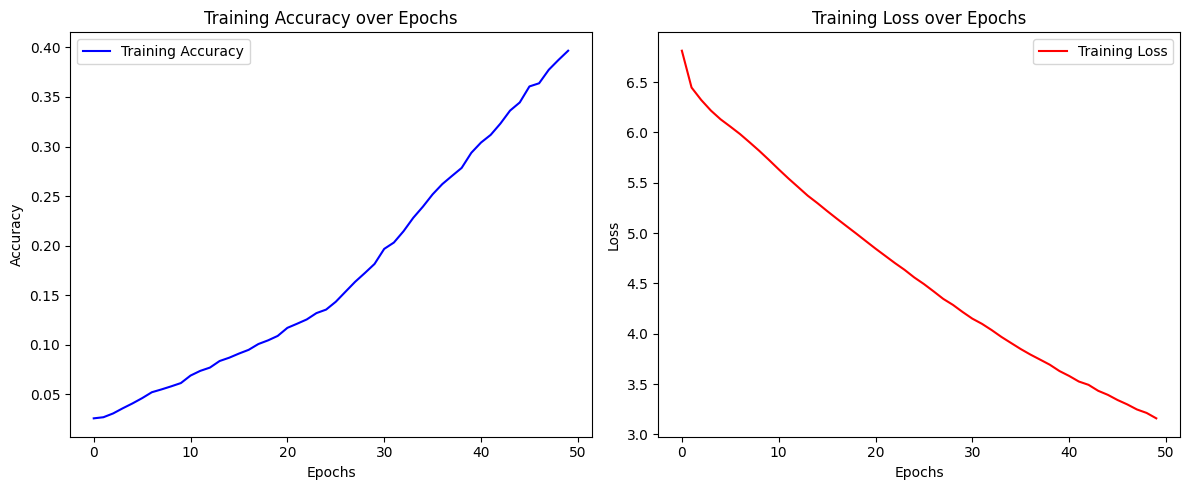

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy', color='blue')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss', color='red')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Generate text with the model based on a seed text

Now you will create two variables :

- seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
- next_words = number_of_words_you_want_the_model_to_generate

Please change number_of_words_you_want_the_model_to_generate by an actual integer.

In [22]:
seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
next_words = 20  # number of words the model will generate


Now create a loop that runs based on the next_words variable and generates new text based on your seed_text input string. Print the full text with the generated text at the end.

This time you dont get detailed instructions.

Have fun!

In [23]:
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted, axis=-1)[0]

    # Find the word from the index
    output_word = ''
    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            output_word = word
            break

    seed_text += ' ' + output_word

print(seed_text)


Write the text you want the model to use as a starting point to generate the next words sang taken luck sit bide now buried near old hide thee 'will ' lies still dearer ' luck dead spent


Experiment with at least 3 different seed_text strings and see what happens!

In [24]:
seed_texts = [
    "The sun was setting over the horizon",
    "In the middle of the dark forest",
    "Technology will change the future of"
]

next_words = 20  # number of words to generate

for seed in seed_texts:
    current_text = seed
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([current_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict(token_list, verbose=0)
        predicted_word_index = np.argmax(predicted, axis=-1)[0]

        # Map index back to word
        output_word = ''
        for word, index in tokenizer.word_index.items():
            if index == predicted_word_index:
                output_word = word
                break

        current_text += ' ' + output_word

    print(f"\nSeed: {seed}")
    print(f"Generated: {current_text}")



Seed: The sun was setting over the horizon
Generated: The sun was setting over the horizon very tomb of youth old praise ' luck prove memory hate green me press free green my sight were hence

Seed: In the middle of the dark forest
Generated: In the middle of the dark forest can ride ' deem luck taken luck taken luck taken ' deem live now 'greeing one shade transferr'd so spent

Seed: Technology will change the future of
Generated: Technology will change the future of world may be kill me pain still kind of rolling one shade be prove thee bright love bright love wrong
